# Notebook that reproduces the results from the paper "Who Let the Trolls Out? Towards Understanding State-Sponsored Trolls"


If you find useful or use code from this notebook please cite:

    @article{zannettou2018let,
      title={{Who Let The Trolls Out? Towards Understanding State-Sponsored Trolls}},
      author={Zannettou, Savvas and Caulfield, Tristan and Setzer, William and Sirivianos, Michael and Stringhini, Gianluca and Blackburn, Jeremy},
      journal={arXiv preprint arXiv:1811.03130},
      year={2018}
    }


In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import json
import tldextract
import re
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from matplotlib.ticker import FuncFormatter
import gensim
from gensim.parsing import PorterStemmer
import networkx as nx
from dateutil.relativedelta import relativedelta
import ast
import warnings
warnings.filterwarnings('ignore')
from ttp import ttp
p = ttp.Parser()

t_col = "#235dba"
g_col = "#005916"
c_col = "#a50808"
r_col = "#ff9900"
black = "#000000"
pink = "#f442f1"
t_ls = '-'
r_ls = '--'
c_ls = ':'
g_ls = '-.'
colors = [t_col, c_col, g_col, r_col, black, 'c', 'm', pink]
line_styles = [t_ls, r_ls, c_ls, g_ls,t_ls, r_ls, c_ls, g_ls, t_ls]

# Load Datasets

In [2]:
# load the dataset provided by Twitter
russians_df_all = pd.read_csv('./data/ira_tweets_csv_hashed.csv')
iranians_df_all = pd.read_csv('./data/iranian_tweets_csv_hashed.csv')
russians_df_users = pd.read_csv('./data/ira_users_csv_hashed')
iranians_df_users = pd.read_csv('./data/iranian_users_csv_hashed')

In [3]:
# load the dataset from Reddit
submissions_trolls = pd.read_json('./data/reddit_troll_submissions.txt', lines=True)
comments_trolls = pd.read_json('./data/reddit_troll_comments.txt', lines=True)
submissions_trolls['is_submission'] = True
comments_trolls['is_comment'] = True
russians_reddit = pd.concat([submissions_trolls, comments_trolls])
russians_reddit['datetime'] = pd.to_datetime(russians_reddit['created_utc'], unit='s')

russian_trolls_reddit = []
with open('./data/russian_trolls_reddit.txt', 'r') as f:
    for line in f:
        russian_trolls_reddit.append(line.replace('\n', ''))
        

# Table 1 (Dataset Statistics)

In [4]:
table_1 = pd.DataFrame([{'platform':'Twitter',
                         'Origin': 'Russia',
                         '# trolls': len(set(russians_df_users['userid'].tolist())),
                         '# of trolls with posts': len(set(russians_df_all['userid'].tolist())),
                         '# of posts': russians_df_all.shape[0]
                        },
                        {'platform':'Twitter',
                         'Origin': 'Iran',
                         '# trolls': len(set(iranians_df_users['userid'].tolist())),
                         '# of trolls with posts': len(set(iranians_df_all['userid'].tolist())),
                         '# of posts': iranians_df_all.shape[0]
                        },
                        {'platform':'Reddit',
                         'Origin': 'Russia',
                         '# trolls': len(set(russian_trolls_reddit)),
                         '# of trolls with posts': len(set(russians_reddit['author'].tolist())),
                         '# of posts': russians_reddit.shape[0]
                        }
                       ],)
table_1

,# of posts,# of trolls with posts,# trolls,Origin,platform
0,9041308,3667,3836,Russia,Twitter
1,1122936,660,770,Iran,Twitter
2,21321,335,944,Russia,Reddit


# Figure 1 (Account Creation per Week)

In [5]:
# load account creation dates from Reddit
reddit_a = []
with open('./data/troll_account_data.txt', 'r') as f:
    for line in f:
        try:
            data = json.loads(line)['data']
        except:
            continue
        reddit_a.append(data)

reddit_accounts = pd.DataFrame(reddit_a)
reddit_accounts['datetime_m'] = pd.to_datetime(reddit_accounts['created_utc'], unit='s') 

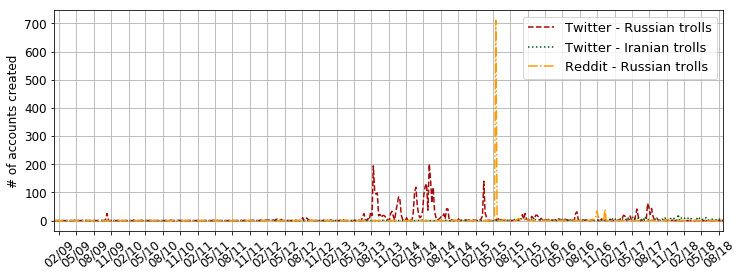

In [6]:
def get_counts_day(df, key, user_key):
    df['datetime'] = pd.to_datetime(df[key])
    df = df[[user_key,key, 'datetime']].drop_duplicates()    
    start_date = '2009-01-01'
    end_date = '2018-08-31'
    counts_month = df[[user_key, 'datetime']].groupby(pd.Grouper(key='datetime', freq='w')).count()
    counts_month.index = pd.DatetimeIndex(counts_month.index)
    idx = pd.date_range(start_date, end_date, freq='w')
    counts_month = counts_month.reindex(idx, fill_value=0)
    return counts_month
    
def plot_days_counts_agg(list_days_and_counts, path, leg, colors, lines):
    fig, ax = plt.subplots(figsize=(12,4.5))

    k=0
    for days_and_counts in list_days_and_counts:
        counts = [x[0] for x in days_and_counts]
        days = [datetime.strptime(x[1], '%d-%m-%Y') for x in days_and_counts]
        days2 = mdates.date2num(days)
        ax.plot_date(days2, counts, colors[k], linestyle=lines[k])
        k+=1

    months = mdates.MonthLocator(range(1,13), bymonthday=1, interval=3)
    monthsFmt = mdates.DateFormatter("%m/%y")     
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(monthsFmt)
    ax.autoscale_view()

    fig.autofmt_xdate()
    plt.ylabel('# of accounts created')
    plt.grid()
    plt.xticks(rotation=40)
    plt.legend(leg, loc='best', fontsize=13)
    plt.margins(x=0)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_horizontalalignment('center')
    for item in ([ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    plt.savefig(path, bbox_inches='tight')
    plt.show()

# russians twitter
counts_day2 = get_counts_day(russians_df_all, 'account_creation_date', 'userid')
counts_per_day2 = counts_day2['userid'].tolist()
days2 = counts_day2.index.date.tolist()
filter_days2 = [ (i, j.strftime('%d-%m-%Y')) for (i,j) in zip(counts_per_day2, days2) ]

# iranians twitter
counts_day3 = get_counts_day(iranians_df_all, 'account_creation_date', 'userid')
counts_per_day3 = counts_day3['userid'].tolist()
days3 = counts_day3.index.date.tolist()
filter_days3 = [ (i, j.strftime('%d-%m-%Y')) for (i,j) in zip(counts_per_day3, days3) ]

# reddit iranians
counts_day4 = get_counts_day(reddit_accounts, 'datetime_m', 'name')
counts_per_day4 = counts_day4['name'].tolist()
days4 = counts_day4.index.date.tolist()
filter_days4 = [ (i, j.strftime('%d-%m-%Y')) for (i,j) in zip(counts_per_day4, days4) ]

plot_days_counts_agg([filter_days2,filter_days3, filter_days4], path='./figures/counts_created_accounts_week_agg.pdf',
                    colors=colors[1:], lines=line_styles[1:], leg=['Twitter - Russian trolls', 'Twitter - Iranian trolls', 'Reddit - Russian trolls'],)


# Figure 2 (Distribution of Followers/Friends)

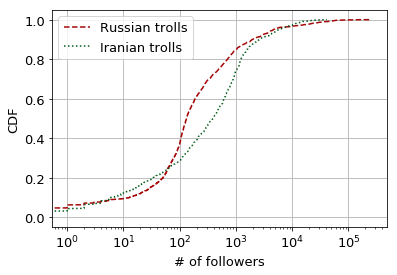

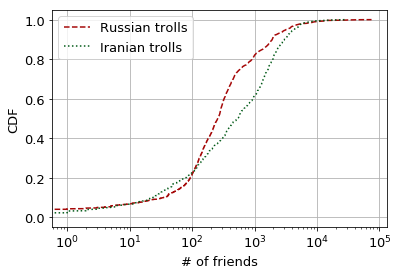

In [7]:
# plots cdfs
def plot_cdf(list_counts, xlabel, path, leg=False, islogx=True, xlimit=False):
    t_col = "#235dba"
    g_col = "#005916"
    c_col = "#a50808"
    r_col = "#ff9900"
    black = "#000000"
    pink = "#f442f1"
    t_ls = '-'
    r_ls = '--'
    c_ls = ':'
    g_ls = '-.'

    markers = [".", "o", "v", "^", "<", ">", "1", "2"]
    colors = [t_col, c_col, g_col, r_col, black, 'c', 'm', pink]
    line_styles = [t_ls, r_ls, c_ls, g_ls,t_ls, r_ls, c_ls, g_ls, t_ls]
    colors = colors[1:]
    line_styles= line_styles[1:]
    while(len(list_counts) > len(colors)):
        colors = colors + shuffle(colors)
        line_styles = line_styles + shuffle(line_styles)
        
    if xlimit:
        l2 = []
        for l in list_counts:
            l2_1 = [x for x in l if x<=xlimit]
            l2.append(l2_1)
        list_counts = l2
    
    for l in list_counts:
        l.sort()
    fig, ax = plt.subplots(figsize=(6,4))
    yvals = []
    for l in list_counts:
        yvals.append(np.arange(len(l))/float(len(l)-1))
    for i in range(len(list_counts)):
        ax.plot(list_counts[i], yvals[i], color=colors[i], linestyle=line_styles[i])
    if islogx:
        ax.set_xscale("log")
    plt.xlabel(xlabel)
    plt.ylabel('CDF')
    plt.grid()
    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(13)
    
    if leg:
        plt.legend(leg, loc='best', fontsize=13)
    
    plt.show()
    fig.savefig(path, bbox_inches='tight')

list_of_counts_followers = [russians_df_all[['userid', 'follower_count']].drop_duplicates()['follower_count'].tolist(),
                            iranians_df_all[['userid', 'follower_count']].drop_duplicates()['follower_count'].tolist()]#, dfall_random['user_followers'].tolist()]


plot_cdf(list_of_counts_followers, 
        '# of followers',
        leg=['Russian trolls', 'Iranian trolls'],
        path='./figures/cdf_followers.pdf',
        islogx=True)

list_of_counts_followings = [russians_df_all[['userid', 'following_count']].drop_duplicates()['following_count'].tolist(),
                            iranians_df_all[['userid', 'following_count']].drop_duplicates()['following_count'].tolist()]#, dfall_random['user_friends'].tolist()]


plot_cdf(list_of_counts_followings, 
        '# of friends',
        leg=['Russian trolls', 'Iranian trolls'],
        path='./figures/cdf_followings.pdf',
        islogx=True)


# Figure 3 (Temporal Analysis)

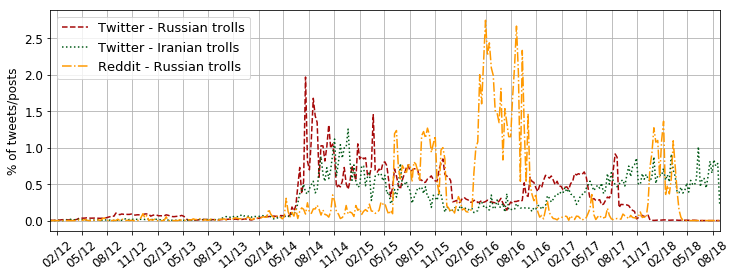

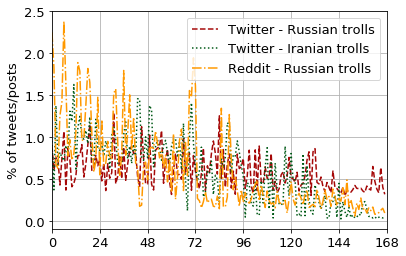

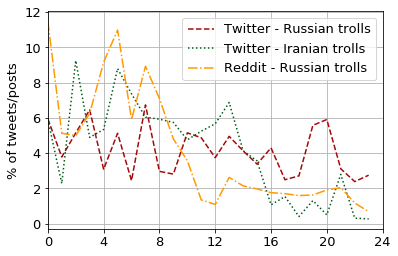

In [8]:
russians_df_all['datetime'] = pd.to_datetime(russians_df_all['tweet_time'])
iranians_df_all['datetime'] = pd.to_datetime(iranians_df_all['tweet_time'])

def get_counts_day2(df, key):
    counts_month = df[[key, 'datetime']].groupby(pd.Grouper(key='datetime', freq='w')).count()
    start_date = '2012-01-01'
    end_date = '2018-08-31'

    counts_month.index = pd.DatetimeIndex(counts_month.index)
    idx = pd.date_range(start_date, end_date, freq='w')
    counts_month = counts_month.reindex(idx, fill_value=0)
    counts_month.index = pd.DatetimeIndex(counts_month.index)
    return counts_month

filter_days_all_general = []
dfs = [russians_df_all, iranians_df_all, russians_reddit ]

keys = ['tweetid', 'tweetid', 'id']
for i in range(len(dfs)):
    df = dfs[i]
    k = keys[i]
    counts_day = get_counts_day2(df, k)
    counts_per_day = counts_day[k].tolist()
    days = counts_day.index.date.tolist()
    filter_days = [ (i, j.strftime('%d-%m-%Y')) for (i,j) in zip(counts_per_day, days) ]
    filter_days_all_general.append(filter_days[1:])

    
def plot_days_counts(days_and_counts_list, colors, lines, path, leg=False, 
                     ylabel='% of tweets/posts'):
    percs_all = []
    fig, ax = plt.subplots(figsize=(12,4.5))
    k=0
    for days_and_counts in days_and_counts_list:
        counts = [x[0] for x in days_and_counts]
        d_s = sum(counts)
        days = [datetime.strptime(x[1], '%d-%m-%Y') for x in days_and_counts]
        days2 = mdates.date2num(days)
        percs = [x/float(d_s)*100 for x in counts]
        percs_all.append(percs)
        ax.plot_date(days2, percs, colors[k], linestyle=lines[k])
        k+=1
            
    months = mdates.MonthLocator(range(1,13), bymonthday=1, interval=3)
    monthsFmt = mdates.DateFormatter("%m/%y")

    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(monthsFmt)
    ax.autoscale_view()
    fig.autofmt_xdate()
    plt.ylabel(ylabel)
    plt.margins(x=0)
   
    plt.xticks(rotation=40)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_horizontalalignment('center')
    for item in ([ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    plt.grid()
    plt.legend(leg, loc='best', fontsize=13)
    plt.savefig(path, bbox_inches='tight')
    plt.show()
    
plot_days_counts(filter_days_all_general, colors[1:], line_styles[1:], path='./figures/counts_per_day.pdf', 
                 leg=['Twitter - Russian trolls', 'Twitter - Iranian trolls', 'Reddit - Russian trolls'])


datetimes_russian_full = russians_df_all['datetime'].tolist()
datetimes_iranians = iranians_df_all['datetime'].tolist()
datetimes_russians_reddit = russians_reddit['datetime'].tolist()
datetimes_all = [datetimes_russian_full, datetimes_iranians, datetimes_russians_reddit]

def thousands(x, pos):
    'The two args are the value and tick position'
    return '%.1fK' % (x*1e-3)


def plot_hour_of_week(all_datetimes, colors, lines):
    percs_all = []
    for datetime_single in all_datetimes:
        counts = []
        for datetim in datetime_single:
            day = datetim.weekday()
            hour = datetim.hour
            hour_week = (day * 24) + hour
            counts.append(hour_week)
        data = Counter(counts).items()
        counts_only = [x[1] for x in data]
        percs = [(x/float(sum(counts_only)))*100 for x in counts_only ]
        percs_all.append(percs)
        
    xs = []
    for perc in percs_all:
        xs.append(np.arange(0, len(perc)))
    
    plt.figure(figsize=(6,4))
    for i in range(len(percs_all)):
        plt.plot(xs[i], percs_all[i], colors[i], linestyle=lines[i])
    plt.xlim(1, len(percs_all[0]))
    ax = plt.gca()
    plt.ylabel('% of tweets/posts')
    plt.grid()

    plt.xticks(np.arange(0, 169, 24))   

    for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(13)
    plt.legend([ 'Twitter - Russian trolls', 'Twitter - Iranian trolls', 'Reddit - Russian trolls'], 
               loc='best', fontsize=13)

    plt.savefig('./figures/counts_per_hour_week.pdf', bbox_inches='tight')
    plt.show()
                  
plot_hour_of_week(datetimes_all ,colors[1:], line_styles[1:])




def plot_hour_of_day(all_datetimes, colors, lines):

    percs_all = []
    for datetime_single in all_datetimes:
        counts = []
        for datetim in datetime_single:
            hour = datetim.hour
            counts.append(hour+1)
        data = Counter(counts).items()
        counts_only = [x[1] for x in data]
        percs = [(x/float(sum(counts_only)))*100 for x in counts_only ]
        percs_all.append(percs)
        
    xs = []
    for perc in percs_all:
        xs.append(np.arange(0, len(perc)))
    
    plt.figure(figsize=(6,4))
    for i in range(len(percs_all)):
        plt.plot(xs[i], percs_all[i], colors[i], linestyle=lines[i])
    plt.xlim(1, len(percs_all[0]))
    ax = plt.gca()
    plt.ylabel('% of tweets/posts')
    plt.grid()
    ax = plt.gca()
  
    plt.xticks(np.arange(0, 25, 4)) 

    for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(13)
    
    plt.legend([ 'Twitter - Russian trolls', 'Twitter - Iranian trolls',
                'Reddit - Russian trolls'], loc='best', fontsize=13)
    plt.savefig('./figures/counts_per_hour_day.pdf', bbox_inches='tight')
    plt.show()
    

plot_hour_of_day(datetimes_all ,colors[1:], line_styles[1:])


# Figure 4 (Unique trolls that were active per week)

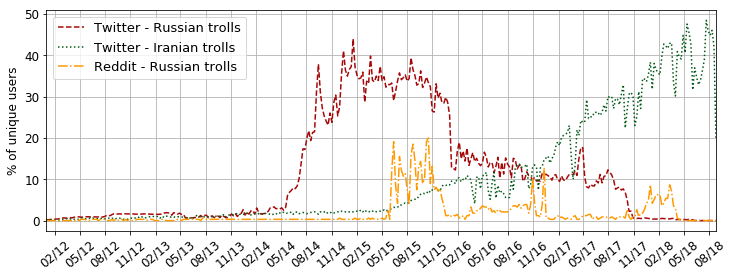

In [9]:
def get_unique_users_per_day(df, key):
    counts_month = df[[key, 'datetime']].groupby(pd.Grouper(key='datetime', freq='w'))[key].nunique()    
    start_date = '2012-01-01'
    end_date = '2018-08-31'

    counts_month.index = pd.DatetimeIndex(counts_month.index)
    idx = pd.date_range(start_date, end_date, freq='w')
    counts_month = counts_month.reindex(idx, fill_value=0)
    counts_month.index = pd.DatetimeIndex(counts_month.index)

    return counts_month

def plot_unique_users(days_and_counts_list, norm_counts, colors, lines, path, leg=False, ylabel='# of unique users'):
    percs_all = []
    fig, ax = plt.subplots(figsize=(12,4.5))
    k=0
    for days_and_counts in days_and_counts_list:
        counts = [x[0] for x in days_and_counts]
        d_s = norm_counts[k]
        days = [datetime.strptime(x[1], '%d-%m-%Y') for x in days_and_counts]
        days2 = mdates.date2num(days)
        percs = [x/float(d_s)*100 for x in counts]
        percs_all.append(percs)
        ax.plot_date(days2, percs, colors[k], linestyle=lines[k])
        k+=1
    
    months = mdates.MonthLocator(range(1,13), bymonthday=1, interval=3)
    monthsFmt = mdates.DateFormatter("%m/%y")
    
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(monthsFmt)
    ax.autoscale_view()
    fig.autofmt_xdate()

    plt.ylabel(ylabel)
    plt.margins(x=0)
   
    plt.xticks(rotation=40)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_horizontalalignment('center')
    for item in ([ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    
    plt.grid()
    plt.legend(leg, loc='best', fontsize=13)
    plt.savefig(path, bbox_inches='tight')
    plt.show()
    

dfs = [russians_df_all, iranians_df_all, russians_reddit]
keys = ['userid', 'userid', 'author']
filter_days_all = []
norms_all = []
for i in range(len(dfs)):
    df = dfs[i]
    counts_week = get_unique_users_per_day(dfs[i], keys[i])
    counts_per_week = counts_week.values
    weeks = counts_week.index
    filter_days = [ (i, j.strftime('%d-%m-%Y')) for (i,j) in zip(counts_per_week, weeks) ]
    norm = len(set(df[keys[i]].tolist()))
    filter_days_all.append(filter_days)
    norms_all.append(norm)


plot_unique_users(filter_days_all, norms_all, colors[1:], line_styles[1:],
                  './figures/unique_users_per_week.pdf', ylabel='% of unique users',
                  leg=['Twitter - Russian trolls', 'Twitter - Iranian trolls',
                       'Reddit - Russian trolls'])

# Figure 5 (First and last post of each troll account)

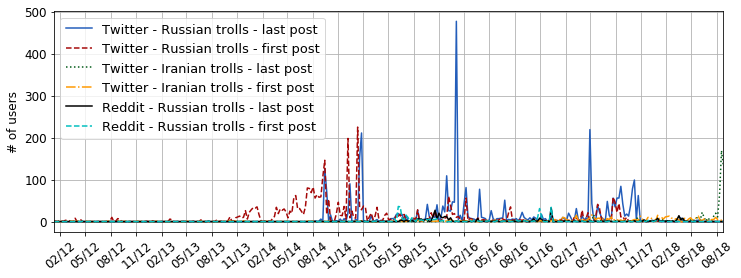

In [10]:
def plot_temporal(days_and_counts_list, colors, lines, path, leg=False, ylabel='# of unique users', islogy=False):
    percs_all = []
    fig, ax = plt.subplots(figsize=(12,4.5))
    k=0
    for days_and_counts in days_and_counts_list:
        counts = [x[0] for x in days_and_counts]
        d_s = sum(counts)
        days = [datetime.strptime(x[1], '%d-%m-%Y') for x in days_and_counts]
        days2 = mdates.date2num(days)
        percs = [x/float(d_s)*100 for x in counts]
        percs_all.append(counts)
        ax.plot_date(days2, counts, colors[k], linestyle=lines[k])
        k+=1
    
    months = mdates.MonthLocator(range(1,13), bymonthday=1, interval=3)
    monthsFmt = mdates.DateFormatter("%m/%y")

    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(monthsFmt)
    ax.autoscale_view()
    fig.autofmt_xdate()
    if islogy:
        ax.set_yscale("log")
    plt.ylabel(ylabel)
    plt.margins(x=0)
   
    plt.xticks(rotation=40)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_horizontalalignment('center')
    for item in ([ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    
    plt.grid()
    if leg:
        plt.legend(leg, loc='best', fontsize=13)
    plt.savefig(path, bbox_inches='tight')
    plt.show()

russians_last = russians_df_all.sort_values(['datetime'],ascending=False).groupby('userid').head(1)
russians_first = russians_df_all.sort_values(['datetime']).groupby('userid').head(1)
iranians_last = iranians_df_all.sort_values(['datetime'],ascending=False).groupby('userid').head(1)
iranians_first = iranians_df_all.sort_values(['datetime']).groupby('userid').head(1)
russians_reddit_last = russians_reddit.sort_values(['datetime'], ascending=False).groupby('author').head(1)
russians_reddit_first = russians_reddit.sort_values(['datetime']).groupby('author').head(1)


dfs = [russians_last, russians_first, iranians_last, iranians_first, russians_reddit_last, russians_reddit_first]
keys = ['tweetid','tweetid','tweetid','tweetid','id', 'id']
filter_days_all = []
for i in range(len(dfs)):
    df = dfs[i]
    key = keys[i]
    counts_day = get_counts_day2(df, key)
    counts_per_day = counts_day[key].tolist()
    days = counts_day.index.date.tolist()
    filter_days = [ (i, j.strftime('%d-%m-%Y')) for (i,j) in zip(counts_per_day, days) ]
    filter_days_all.append(filter_days[1:])

plot_temporal(filter_days_all, colors, line_styles,'./figures/temporal_first_last.pdf', 
                  leg = ['Twitter - Russian trolls - last post', 
                        'Twitter - Russian trolls - first post', 
                       'Twitter - Iranian trolls - last post', 
                       'Twitter - Iranian trolls - first post',
                       'Reddit - Russian trolls - last post', 
                       'Reddit - Russian trolls - first post'], ylabel='# of users')

# Figure 6 (Mentions/Retweets among Trolls)

##### (the following cell takes some time to finish)

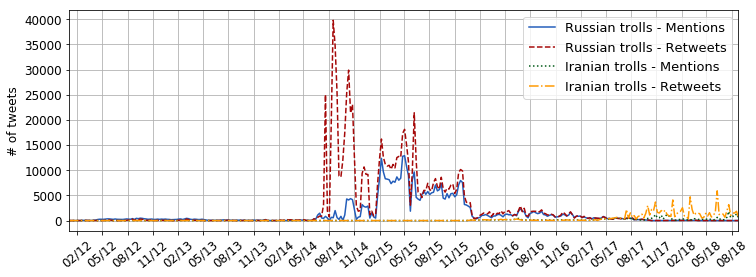

In [11]:
def find_mentions(text):
    try:
        result = p.parse(text)
        return result.users
    except:
        return False

def find_hashtags(text):
    try:
        result = p.parse(text)
        return result.tags
    except:
        return False
    
def find_if_they_mention(df, list_user_names):
    df2 = df[(df.mentions!=False)&(df.mentions.notnull())]
    mask = df2.mentions.apply(lambda x: len(set(list_user_names) &set(x))>0)
    df1 = df2[mask]
    return df1

def find_if_they_retweet_each_other(df, list_user_ids):
    df_replies = df[df.retweet_userid.notnull()]
    df_replies_filt = df_replies[df.retweet_userid.isin(list_user_ids)]
    return df_replies_filt


russians_df_all['mentions'] = russians_df_all['tweet_text'].map(find_mentions)
iranians_df_all['mentions'] = iranians_df_all['tweet_text'].map(find_mentions)
russians_df_all['hashtags'] = russians_df_all['tweet_text'].map(find_hashtags)
iranians_df_all['hashtags'] = iranians_df_all['tweet_text'].map(find_hashtags)

iranians_mentions_among = find_if_they_mention(iranians_df_all, list(set(iranians_df_all['user_screen_name'])))
russians_mentions_among = find_if_they_mention(russians_df_all, list(set(russians_df_all['user_screen_name'])))
russians_retweets = find_if_they_retweet_each_other(russians_df_all, list(set(russians_df_all['userid'].tolist())))
iranians_retweets = find_if_they_retweet_each_other(iranians_df_all, list(set(iranians_df_all['userid'].tolist())))


dfs = [russians_mentions_among, russians_retweets, iranians_mentions_among, iranians_retweets]
filter_all = []
for df in dfs:
    counts_day = get_counts_day2(df, 'tweetid')
    counts_per_day = counts_day['tweetid'].tolist()
    days = counts_day.index.date.tolist()
    filter_days = [ (i, j.strftime('%d-%m-%Y')) for (i,j) in zip(counts_per_day, days) ]
    filter_all.append(filter_days)
plot_temporal(filter_all, colors, line_styles, path='./figures/counts_per_week_among_agg.pdf',
              ylabel='# of tweets', leg=['Russian trolls - Mentions', 
                                         'Russian trolls - Retweets', 
                                         'Iranian trolls - Mentions', 
                                         'Iranian trolls - Retweets'])

# Figure 7 (CDF of languages and clients)

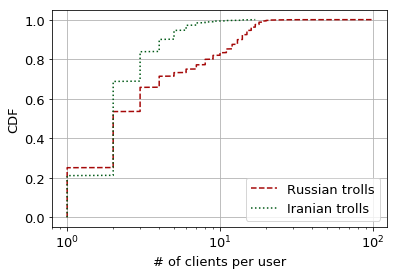

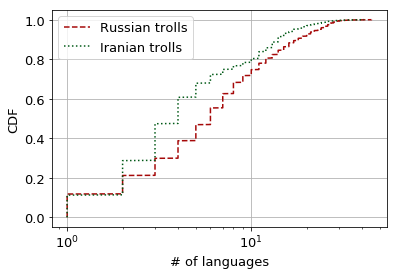

In [12]:
def per_user_stat(df, user_id_key, target_key):
    res_dict = {}
    grouped = df.groupby(user_id_key)
    for name, group in grouped:
        res_dict[group.iloc[0][user_id_key]] = len(set(group[target_key].tolist()))
    return list(res_dict.values())

number_of_sources_per_user_russians_all = per_user_stat(russians_df_all, 'userid',
                                                        'tweet_client_name')
number_of_sources_per_user_iranians_all = per_user_stat(iranians_df_all, 'userid',
                                                        'tweet_client_name')

list_of_counts_sources = [number_of_sources_per_user_russians_all, 
                          number_of_sources_per_user_iranians_all]
plot_cdf(list_of_counts_sources,
         '# of clients per user', 
         leg=['Russian trolls', 'Iranian trolls'],
         path='./figures/cdf_sources_user.pdf',
        islogx=True)

number_of_languages_per_user_russians_all = per_user_stat(russians_df_all, 'userid',
                                                          'tweet_language')
number_of_languages_per_user_iranians = per_user_stat(iranians_df_all, 'userid',
                                                      'tweet_language')

list_of_counts_languages = [number_of_languages_per_user_russians_all,
                            number_of_languages_per_user_iranians]
plot_cdf(list_of_counts_languages,
         '# of languages', 
         leg=['Russian trolls', 'Iranian trolls'],
         path='./figures/cdf_languages_user.pdf',
        islogx=True)


# Figure 8 (Use of languages over time)

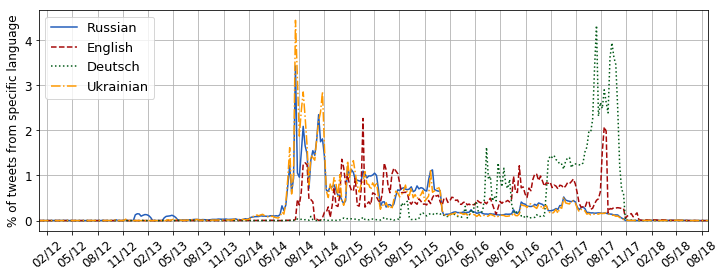

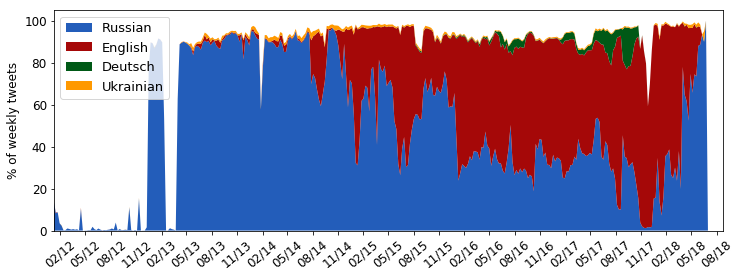

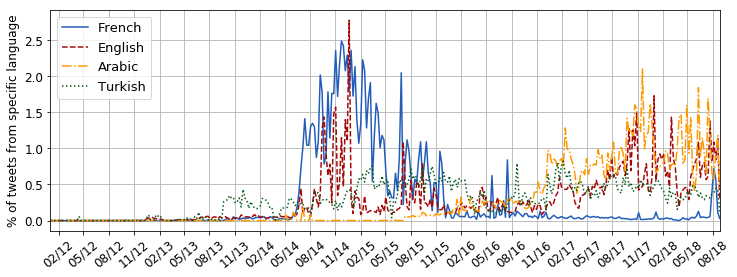

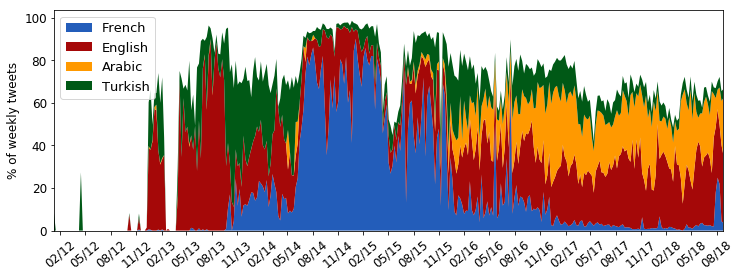

In [13]:
def plot_days_counts_lang(days_and_counts_list, overall_counts, colors, lines, path, leg=False):
    percs_all = []
    fig, ax = plt.subplots(figsize=(12,4.5))
    k=0
    for days_and_counts in days_and_counts_list:
        counts = [x[0] for x in days_and_counts]
        d_s = sum(counts)
        days = [datetime.strptime(x[1], '%d-%m-%Y') for x in days_and_counts]
        days2 = mdates.date2num(days)
        percs = [x/float(overall_counts)*100 for x in counts]
        percs_all.append(percs)
        ax.plot_date(days2, percs, colors[k], linestyle=lines[k])
        k+=1

    
    months = mdates.MonthLocator(range(1,13), bymonthday=1, interval=3)
    monthsFmt = mdates.DateFormatter("%m/%y")

    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(monthsFmt)
    ax.autoscale_view()
    fig.autofmt_xdate()
    plt.margins(x=0)
    plt.ylabel('% of tweets')
    plt.grid()
    plt.xticks(rotation=40)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_horizontalalignment('center')
    for item in ([ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    if leg:
        plt.legend(leg, loc='best', fontsize=13)
    plt.savefig(path, bbox_inches='tight')
    plt.show()

def plot_days_counts_lang_norm_week(days_and_counts_list, overall_counts, colors, lines, 
                                    path, leg=False, y_scale_log=False, legontop=False):
    percs_all = []
    fig, ax = plt.subplots(figsize=(12,4.5))
    k=0
    for days_and_counts in days_and_counts_list:
        
        counts = [x[0] for x in days_and_counts[1:]]
        d_s = sum(counts)
        days = [datetime.strptime(x[1], '%d-%m-%Y') for x in days_and_counts]
        days2 = mdates.date2num(days)
        percs = []
        for i in range(len(counts)):
            try:
                percs.append(counts[i]/overall_counts[i]*100)
            except ZeroDivisionError:
                percs.append(0.0)
        percs_all.append(percs)
        k+=1
    plt.stackplot(days[1:], percs_all, colors=colors)
    months = mdates.MonthLocator(range(1,13), bymonthday=1, interval=3)
    monthsFmt = mdates.DateFormatter("%m/%y")

    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(monthsFmt)
    ax.autoscale_view()
    fig.autofmt_xdate()
    if y_scale_log:
        ax.set_yscale("log")
    plt.ylabel('% of weekly tweets')
    plt.margins(x=0)

    plt.xticks(rotation=40)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_horizontalalignment('center')
    for item in ([ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    if leg:
        if legontop==False:
            plt.legend(leg, loc=2, fontsize=13)
        else:
            plt.legend(leg,  bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=4, mode="expand", borderaxespad=0., fontsize=13)
    plt.savefig(path, bbox_inches='tight')
    plt.show()


overall_counts_iranians = [x[0] for x in filter_days_all_general[1]]
overall_counts_russians = [x[0] for x in filter_days_all_general[0]]

languages = ['ru', 'en', 'de','uk']
filters = []
for language in languages:
    counts_day = get_counts_day2(russians_df_all[russians_df_all.tweet_language==language], 'tweetid')
    counts_per_day = counts_day['tweetid'].tolist()
    days = counts_day.index.date.tolist()
    filter_days = [ (i, j.strftime('%d-%m-%Y')) for (i,j) in zip(counts_per_day, days)]
    filters.append(filter_days)
    
plot_days_counts(filters, colors, line_styles, path='./figures/counts_per_week_norm_language_posts_russians.pdf',
                 leg=['Russian', 'English', 'Deutsch', 'Ukrainian'], 
                 ylabel='% of tweets from specific language')

plot_days_counts_lang_norm_week(filters, overall_counts_russians, colors, line_styles,
                                path='./figures/counts_per_week_language_russians_norm_week.pdf',
                                leg=['Russian', 'English', 'Deutsch', 'Ukrainian'])

colors_iranians = [colors[0], colors[1], colors[3], colors[2]]
linestyles_iranians = [line_styles[0], line_styles[1], line_styles[3], line_styles[2]]
languages = ['fr', 'en', 'ar', 'tr']
filters = []
for language in languages:
    counts_day = get_counts_day2(iranians_df_all[iranians_df_all.tweet_language==language], 'tweetid')
    counts_per_day = counts_day['tweetid'].tolist()
    days = counts_day.index.date.tolist()
    filter_days = [ (i, j.strftime('%d-%m-%Y')) for (i,j) in zip(counts_per_day, days)]
    filters.append(filter_days)

plot_days_counts(filters, colors_iranians, linestyles_iranians, 
                 path='./figures/counts_per_week_norm_language_posts_iranians.pdf',
                 leg=['French', 'English', 'Arabic', 'Turkish'], ylabel='% of tweets from specific language')

plot_days_counts_lang_norm_week(filters, overall_counts_iranians, colors_iranians, linestyles_iranians, 
                                path='./figures/counts_per_week_language_iranians_norm_week.pdf',
                                leg=['French', 'English', 'Arabic', 'Turkish'])

# Figure 9 (Use of Clients over time)

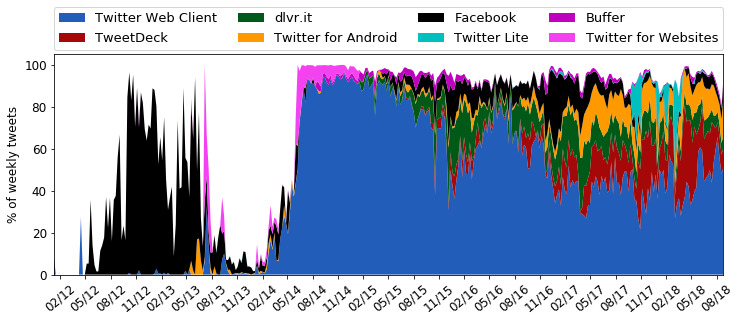

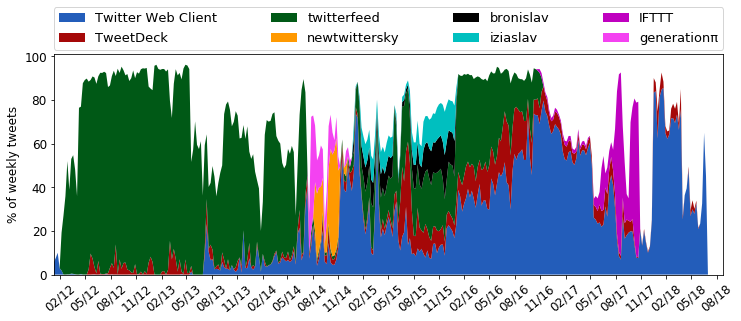

In [14]:
clients = ['Twitter Web Client', 'TweetDeck', 'dlvr.it','Twitter for Android',
           'Facebook','Twitter Lite','Buffer','Twitter for Websites']
filters = []
for client in clients:
    counts_day = get_counts_day2(iranians_df_all[iranians_df_all.tweet_client_name==client], 'tweetid')
    counts_per_day = counts_day['tweetid'].tolist()
    days = counts_day.index.date.tolist()
    filter_days = [ (i, j.strftime('%d-%m-%Y')) for (i,j) in zip(counts_per_day, days)]
    filters.append(filter_days)
plot_days_counts_lang_norm_week(filters, overall_counts_iranians, colors, line_styles, 
                                path='./figures/counts_per_week_clients_iranians_norm_week.pdf',
                                leg=clients, y_scale_log=False, legontop=True)

clients = ['Twitter Web Client', 'TweetDeck','twitterfeed' ,'newtwittersky','bronislav',
           'iziaslav','IFTTT','generationπ']
filters = []
for client in clients:
    counts_day = get_counts_day2(russians_df_all[russians_df_all.tweet_client_name==client], 'tweetid')
    counts_per_day = counts_day['tweetid'].tolist()
    days = counts_day.index.date.tolist()
    filter_days = [ (i, j.strftime('%d-%m-%Y')) for (i,j) in zip(counts_per_day, days)]
    filters.append(filter_days)
plot_days_counts_lang_norm_week(filters, overall_counts_russians, colors, line_styles, 
                                path='./figures/counts_per_week_clients_russians_norm_week.pdf',
                                leg=clients, legontop=True)

# Figure 10 (Map with locations)

See `plot_locations.py` script for generating the map that is in the paper

# Figure 11 (Visualization of hashtags)

The visualization of the graphs is based on the Gephi software (https://gephi.org/). We used the code below to generate the graphs and save them in the `.gexf` format. Subsequently, we imported the files to Gephi and manually performed the operations as they are documented in the paper.
The visualizations can be viewed in the links below:
https://trollspaper2018.github.io/trollspaper.github.io/index.html#russians_graph.gexf
https://trollspaper2018.github.io/trollspaper.github.io/index.html#iranians_graph.gexf

In [15]:
model_russians = gensim.models.Word2Vec.load('./data/trained_models/model_ira_all.w2v')
model_iranians = gensim.models.Word2Vec.load('./data/trained_models/model_iranians_all.w2v')

def to_unique(l):
    return list(set(l))

def create_hashtags_graph_w2v(df, w2v_model, limit=500):
    G = nx.Graph()
    df2 = df[df.hashtags!=False]
    df2['hashtags_uniq'] = df2['hashtags'].map(to_unique)
    global_stemmer = PorterStemmer()
    all_hashtags = df[df.hashtags!=False]['hashtags'].tolist()
    all_hashtags_flat = [item for sublist in all_hashtags for item in sublist]
    hashtag_count = dict(Counter(all_hashtags_flat))
    hashtags_in_graph = []
    for k,v in hashtag_count.items():
        if v>limit:
            G.add_node(k, count=v)
            hashtags_in_graph.append(k)
    for hashtag_i in hashtags_in_graph:
        for hashtag_j in hashtags_in_graph:
            if hashtag_i!=hashtag_j:
                i_stem = global_stemmer.stem(hashtag_i)
                j_stem = global_stemmer.stem(hashtag_j)
                try:
                    similarities = w2v_model.wv.cosine_similarities(w2v_model.wv.get_vector(i_stem),
                                                                    np.array([w2v_model.wv.get_vector(j_stem),
                                                                              w2v_model.wv.get_vector(j_stem)]))
                except KeyError:
                    continue
                distance = 1 -similarities[0]
                if distance<0.4:
                    G.add_edge(hashtag_i, hashtag_j, weight=distance)
    return G

hashtag_graph_russians = create_hashtags_graph_w2v(russians_df_all, model_russians, limit=1300)
nx.write_gexf(hashtag_graph_russians, "russians_hashtags_graph.gexf")
hashtag_graph_iranians = create_hashtags_graph_w2v(iranians_df_all, model_iranians, limit=400)
nx.write_gexf(hashtag_graph_iranians, "iranians_hashtags_graph.gexf")


# Table 2 (Most similar terms to the term 'maga' according to word2vec models)

In [16]:
similar_maga_russians = pd.DataFrame(model_russians.most_similar('maga'), columns=['Term (Russians)',
                                                                                   'Cosine Similarity'])
similar_maga_iranians = pd.DataFrame(model_iranians.most_similar('maga'), columns=['Term (Iranians)',
                                                                                  'Cosine Similarity'])
table_2 = pd.concat([similar_maga_russians, similar_maga_iranians], axis=1)
table_2

,Term (Russians),Cosine Similarity,Term (Iranians),Cosine Similarity
0,trumpsarmi,0.683786,impeachtrump,0.807842
1,trumptrain,0.672737,stoptrump,0.804999
2,votetrump,0.656086,fucktrump,0.797475
3,makeamericagreatagain,0.655915,trumpisamoron,0.796547
4,draintheswamp,0.622843,dumptrump,0.793817
5,trumppenc,0.612136,ivankatrump,0.787172
6,@realdonaldtrump,0.591306,theresist,0.771539
7,wakeupamerica,0.580547,trumpresign,0.764789
8,thursdaythought,0.575318,notmypresid,0.763675
9,realdonaldtrump,0.573161,worstpresidentev,0.753197


# Table 3 (Table 4 in arxiv version, Top Hashtags)

In [17]:
def find_top_hashtags(df, topn, troll_origin):
    all_tweets = df.shape[0]
    hashtags_list = df['hashtags'].tolist()
    hashtags_flat = [item for sublist in hashtags_list for item in sublist]
    counter = Counter(hashtags_flat).most_common(topn)
    res = []
    column_name = 'Hashtag (' + troll_origin + ')' 
    for c in counter:
        
        res.append({column_name: c[0], 'Percentage (%)': c[1]/len(hashtags_flat)*100})
    return res

top_hashtags_russians = pd.DataFrame(find_top_hashtags(russians_df_all[russians_df_all.hashtags!=False], 
                                                       20, 'Russians'))
top_hashtags_iranians = pd.DataFrame(find_top_hashtags(iranians_df_all[iranians_df_all.hashtags!=False], 
                                                       20, 'Iranians'))
table_3 = pd.concat([top_hashtags_russians, top_hashtags_iranians], axis=1)
table_3

,Hashtag (Russians),Percentage (%),Hashtag (Iranians),Percentage (%)
0,news,9.567821,Iran,1.887623
1,sports,3.832425,Trump,1.396049
2,politics,2.996756,Israel,1.106000
3,local,2.115889,Yemen,0.883781
4,world,1.134189,FreePalestine,0.831881
5,MAGA,1.128969,QudsDay4Return,0.791971
6,business,1.050135,US,0.749925
7,Chicago,0.917983,realiran,0.666326
8,health,0.865247,ISIS,0.661070
9,love,0.774117,DeleteIsrael,0.631014


# Figure 12 (Hashtags over time regarding US elections)

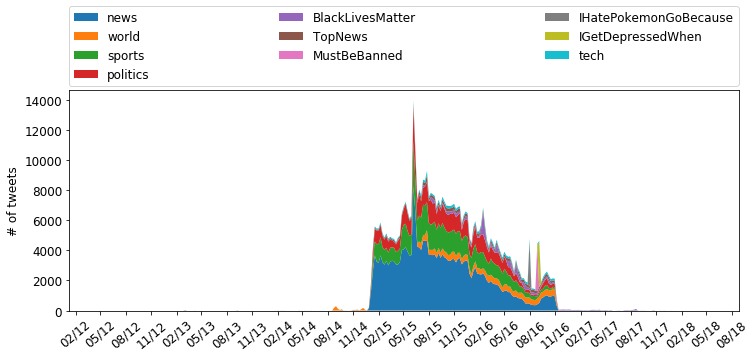

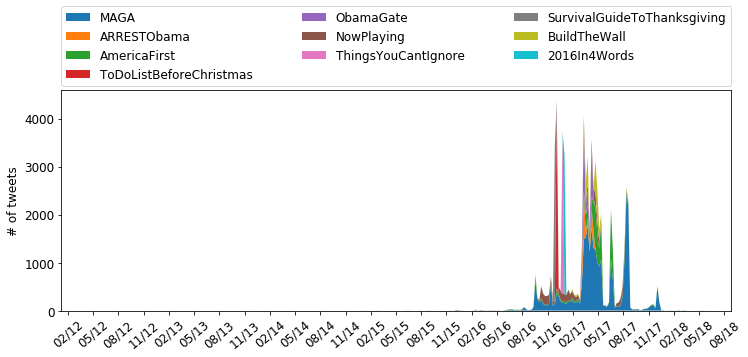

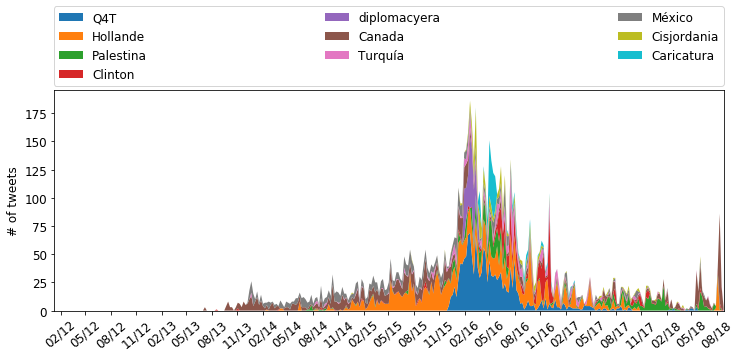

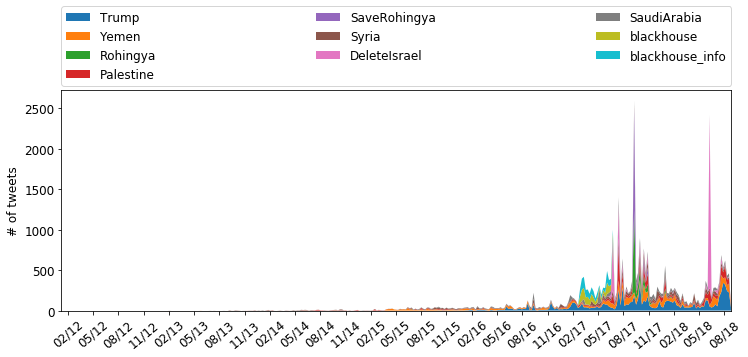

In [18]:
split_date = datetime.strptime('2016-11-10', '%Y-%m-%d')
def find_hashtags_difference(df, split_d, month_diff):
    after = split_d + relativedelta(months=month_diff)
    before= split_d + relativedelta(months=-month_diff)
    df_before = df[(df.datetime>=before)&(df.datetime<split_d)]
    df_after = df[(df.datetime>=split_d)&(df.datetime<=after)]
    
    all_hashtags = df_before['hashtags'].tolist() + df_after['hashtags'].tolist()
    all_hashtags_flat = set([item for sublist in all_hashtags for item in sublist])
    
    counter_before = dict(Counter([item for sublist in df_before['hashtags'].tolist() for item in sublist]))
    counter_after = dict(Counter([item for sublist in df_after['hashtags'].tolist() for item in sublist]))
    interesting = []
    interesting_opposite = []
    for hashtag in all_hashtags_flat:
        try:
            count_before = counter_before[hashtag]
        except:
            count_before = 0
        try:
            count_after = counter_after[hashtag]
        except:
            count_after = 0
            
        try:
            if count_after/count_before < 0.5:
                interesting.append((hashtag, count_before, count_after))
        except:
            pass
            
        try:
            if count_before/count_after < 0.5:
                interesting_opposite.append((hashtag, count_before, count_after))
        except:
            pass
    interesting.sort(key=lambda tup: tup[1], reverse=True)
    interesting_opposite.sort(key=lambda tup: tup[2], reverse=True)
    return interesting, interesting_opposite

interesting_hashtags_election_before, interesting_hashtags_election_after = find_hashtags_difference(russians_df_all[russians_df_all.hashtags!=False], split_date, 6)
interesting_hashtags_election_before_iranians, interesting_hashtags_election_after_iranians = find_hashtags_difference(iranians_df_all, split_date, 12)

def plot_days_counts_hashtags(days_and_counts_list, path, leg=False, legisontop=False):
    percs_all = []
    fig, ax = plt.subplots(figsize=(12,4.5))
    k=0
    for days_and_counts in days_and_counts_list:        
        counts = [x[0] for x in days_and_counts[1:]]
        d_s = sum(counts)
        days = [datetime.strptime(x[1], '%d-%m-%Y') for x in days_and_counts]
        days2 = mdates.date2num(days)
        percs_all.append(counts)
        k+=1

    plt.stackplot(days[1:], percs_all)
    months = mdates.MonthLocator(range(1,13), bymonthday=1, interval=3)
    monthsFmt = mdates.DateFormatter("%m/%y")

    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(monthsFmt)
    ax.autoscale_view()
    fig.autofmt_xdate()
    plt.ylabel('# of tweets')
    plt.margins(x=0)

    plt.xticks(rotation=40)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_horizontalalignment('center')
    for item in ([ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    if leg:
        if legisontop==False:
            plt.legend(leg, loc=2, fontsize=13)
        else:
            plt.legend(leg,  bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand",
                       borderaxespad=0., fontsize=12)
    plt.savefig(path, bbox_inches='tight')
    plt.show()
    
def plot_hashtags_over_time(df, hashtags, key, path):
    
    hashtags_to_plot = []
    for i in hashtags[:10]:
        hashtags_to_plot.append([i[0]])
    filters = []
    for hashtag in hashtags_to_plot:
        df = df[df.hashtags!=False]
        mask = df.hashtags.apply(lambda x: len(set(hashtag) &set(x))>0)
        df1 = df[mask]
        counts_day = get_counts_day2(df1, key)
        counts_per_day = counts_day[key].tolist()
        days = counts_day.index.date.tolist()
        filter_days = [ (i, j.strftime('%d-%m-%Y')) for (i,j) in zip(counts_per_day, days)]
        filters.append(filter_days)
    plot_days_counts_hashtags(filters, path, 
                              leg=[item for sublist in hashtags_to_plot for item in sublist],
                              legisontop=True )
    
plot_hashtags_over_time(russians_df_all, interesting_hashtags_election_before[:10],
                       'tweetid', './figures/hashtags_over_time_interesting_elections.pdf')
plot_hashtags_over_time(russians_df_all, interesting_hashtags_election_after[:10],
                       'tweetid', './figures/hashtags_over_time_interesting_elections_after.pdf')

plot_hashtags_over_time(iranians_df_all, interesting_hashtags_election_before_iranians[:10],
                       'tweetid', './figures/hashtags_over_time_interesting_elections_iranians.pdf')
plot_hashtags_over_time(iranians_df_all, interesting_hashtags_election_after_iranians[:10],
                       'tweetid', './figures/hashtags_over_time_interesting_elections_after_iranians.pdf')



# Figure 13 (Top Subreddits)

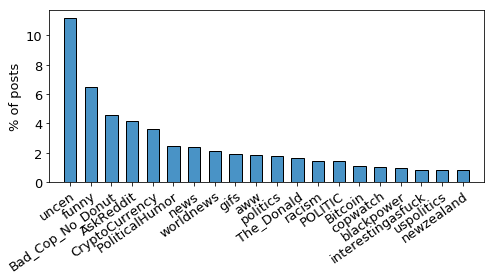

In [19]:
def barchart(bars1, labels, path, ylabel):
    ind = np.arange(len(labels)) 
    width = 0.6    
    fig,ax = plt.subplots(figsize=(7, 4))
    ax.bar(ind, bars1,width,color='#4993C6', edgecolor='#000000')
    ax.set_xticks(ind)
    ax.set_xticklabels(labels,rotation=35, rotation_mode='anchor', ha='right')
    ax.set_ylabel(ylabel)
    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(13)
    plt.tight_layout()
    plt.xlim([-1, len(labels)])
    fig.savefig(path, bbox_inches='tight')
    
counter_subreddits = Counter(russians_reddit['subreddit'].tolist()).most_common(20)
subs = []
percs = []
for c in counter_subreddits:
    subs.append(c[0])
    percs.append(c[1]/russians_reddit.shape[0]*100)
barchart(percs, subs, './figures/bc_top_subreddits.pdf', '% of posts')

# Tables 4 and 5 (Tables 5 and 6 in arxiv version, LDA topics)

Here we load the pretrained models.
If you want to re-train the models see the `run_lda.py` script that trains the models

In [20]:
model_russians_twitter = gensim.models.LdaModel.load('./data/trained_models/lda/model_lda_russians_all')
model_iranians_twitter = gensim.models.LdaModel.load('./data/trained_models/lda/model_lda_iranians_all')
model_russians_reddit = gensim.models.LdaModel.load('./data/trained_models/lda/model_lda_russians_reddit')
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 10000)
def extract_topics_from_model(model, origin_trolls):
    topics_org = []
    lda_topics = model.print_topics(num_topics=10, num_words=10)
    for topic in lda_topics:
        words = []
        elements = topic[1].split('+')
        for i in range(len(elements)):
            topic_word = elements[i].split('*')[-1].replace('\'', '').replace('"', '').replace(' ', '').replace('_', '')
            words.append(topic_word)
        topics_org.append(', '.join(words))
    column_name = "Terms (" + origin_trolls +")"
    return pd.DataFrame({column_name:topics_org})

russians_twitter_table = extract_topics_from_model(model_russians_twitter, 'Russian trolls on Twitter')
iranians_twitter_table = extract_topics_from_model(model_iranians_twitter, 'Iranian trolls on Twitter')
russians_reddit_table  = extract_topics_from_model(model_russians_reddit, 'Russian trolls on Reddit')
table_lda = pd.concat([russians_twitter_table, iranians_twitter_table, russians_reddit_table], axis=1)
table_lda

,Terms (Russian trolls on Twitter),Terms (Iranian trolls on Twitter),Terms (Russian trolls on Reddit)
0,"news, showbiz, photos, baltimore, local, weekend, stocks, friday, small, fatal","isis, first, american, young, siege, open, jihad, success, sydney, turkey","like, also, just, sure, korea, new, crypto, tokens, north, show"
1,"like, just, love, white, black, people, look, got, one, didn","can, people, just, don, will, know, president, putin, like, obama","police, cops, man, officer, video, cop, cute, shooting, year, btc"
2,"day, will, life, today, good, best, one, usa, god, happy","trump, states, united, donald, racist, society, structurally, new, toonsonline, president","old, news, matter, black, lives, days, year, girl, iota, post"
3,"can, don, people, get, know, make, will, never, want, love","saudi, yemen, arabia, israel, war, isis, syria, oil, air, prince","tie, great, bitcoin, ties, now, just, hodl, buy, good, like"
4,"trump, obama, president, politics, will, america, media, breaking, gop, video","iran, front, press, liberty, will, iranian, irantalks, realiran, tehran, nuclear","media, hahaha, thank, obama, mass, rights, use, know, war, case"
5,"news, man, police, local, woman, year, old, killed, shooting, death","attack, usa, days, terrorist, cia, third, pakistan, predict, cfb, cfede","man, black, cop, white, eth, cops, american, quite, recommend, years"
6,"sports, news, game, win, words, nfl, chicago, star, new, beat","israeli, israel, palestinian, palestine, gaza, killed, palestinians, children, women, year","clinton, hillary, one, will, can, definitely, another, job, two, state"
7,"hillary, clinton, now, new, fbi, video, playing, russia, breaking, comey","state, fire, nation, muslim, muslims, rohingya, syrian, sets, ferguson, inferno","trump, will, donald, even, well, can, yeah, true, poor, country"
8,"news, new, politics, state, business, health, world, says, bill, court","syria, isis, turkish, turkey, iraq, russian, president, video, girl, erdo","like, people, don, can, just, think, time, get, want, love"
9,"nyc, everything, tcot, miss, break, super, via, workout, hot, soon","iran, saudi, isis, new, russia, war, chief, israel, arabia, peace","will, can, best, right, really, one, hope, now, something, good"


# Table 6 (Table 7 in arxiv version, Top domains)

In [22]:
# load the mapping between the shortened urls (i.e., bit.ly) and the actual URL
def load_resolved_urls(inp_file):
    mapping = {}
    with open(inp_file, 'r') as f:
        for line in f:
            source, final = line.split('\t')
            final = final.replace('\n', '')
            mapping[source] = final
    return mapping

russians_full_resolved = load_resolved_urls('./data/resolved_urls_shills_full.txt')

def extract_urls_from_string(text):
    # URL extraction regex
    regex = r"(https?:\/\/[-A-Z0-9+&@#\/%?=~_|!:,.;]*[-A-Z0-9+&@#\/%=~_|])"
    res = re.findall(regex, text, re.IGNORECASE)
    domains = set()
    url_list = []
    for url in res:
        tmp = extract_domain(url)
        if tmp:
            domains.add(tmp)
            url_list.append(url)
    return url_list, list(domains)

def extract_domain(url):
    try:
        ext = tldextract.extract(url)
        if len(ext.registered_domain) > 0:    
            return ext.registered_domain
        else:
            return extract_domain2(url)
    except:
        return 'N/A'

def extract_domain2(url):
    regex = r"^(com|edu|gov|ac|net|mil|org|nom|co|name|info|biz|ne|or)$"
    if url is None:
        return False
    url = url.lower()
    url = url.split('?')[0]
    url = url.split('&')[0]
    url = url.split('#')[0]
    #print url
    if url.startswith('http'):
        tmp = url.split('/')
        if len(tmp) > 1:
            tmp = tmp[1]
        else:
            return False
    else:
        tmp = url
    tmp = tmp.split('/')
    if len(tmp) > 0:
        tmp = tmp[0]
    else:
        return False
    if tmp.startswith('www.'):
        tmp = tmp[4:]
    parts = [x for x in reversed(tmp.split('.'))]
    parts = filter(None, parts)
    if len(parts) >= 3:
        matches = re.search(regex, parts[1], re.IGNORECASE)
        if matches:
            return parts[2] + '.' + parts[1] + '.' + parts[0]
    if len(parts) <= 1:
        return False
    return parts[1] + '.' + parts[0]
    
def str_to_list(text):
     return text.replace('[', '').replace(']','').replace(' ', '').split(',')

def find_top_domains(df, topn, origin_trolls, norm_length):
    urls = df[df['urls'].notnull()]['urls'].tolist()
    urls2 = [str_to_list(x) for x in urls]
    urls_flat = [item for sublist in urls2 for item in sublist]
    
    urls_flat2 = []
    for url in urls_flat:
        if 'bit.ly' in url:
            try:
                url2 = russians_full_resolved[url]
                urls_flat2.append(url2)
            except:
                urls_flat2.append(url)
        else:
            urls_flat2.append(url)
        
    domains = [extract_domain(x) for x in urls_flat2]
    counter = Counter([x for x in domains if x!='N/A']).most_common(topn)
    res = []
    column_name = 'Domain (' + origin_trolls + ')' 
    for c in counter:
        res.append({column_name: c[0], 'Percentage (%)': c[1]/norm_length*100})
    return res

def find_top_domains_reddit(df, topn):
    submission_urls = russians_reddit[russians_reddit.is_submission==True]['url'].tolist()
    comments_reddit = russians_reddit[russians_reddit.is_comment==True]
    all_domains_from_submissions = [extract_domain(x) for x in submission_urls]

    all_texts = []
    for idx, row in comments_reddit.iterrows():
        text = str(row['title']) + '' + str(row['selftext']) + ' ' + str(row['body'])
        all_texts.append(text)
    domains_comments = []
    for t in all_texts:
        urls, domains_text = extract_urls_from_string(t)
        for d in domains_text:
            domains_comments.append(d)
        
    all_domains_reddit = all_domains_from_submissions + domains_comments
    counter = Counter(all_domains_reddit).most_common(topn)
    res = []
    for c in counter:
        res.append({'Domain (Russian trolls on Reddit)': c[0], 'Percentage (%)': c[1]/len(all_domains_reddit)*100})
    return res
    
    
russians_table = pd.DataFrame(find_top_domains(russians_df_all, 20, 'Russian trolls on Twitter',
                             russians_df_all.shape[0]))
iranians_table = pd.DataFrame(find_top_domains(iranians_df_all, 20, 'Iranian trolls on Twitter', 
                                               iranians_df_all.shape[0]))
russians_table_reddit = pd.DataFrame(find_top_domains_reddit(russians_reddit, 20))


table_6 = pd.concat([russians_table, iranians_table, russians_table_reddit], axis=1)
table_6

,Domain (Russian trolls on Twitter),Percentage (%),Domain (Iranian trolls on Twitter),Percentage (%),Domain (Russian trolls on Reddit),Percentage (%)
0,livejournal.com,5.432953,awdnews.com,29.342901,imgur.com,27.646937
1,riafan.ru,5.005647,dlvr.it,7.105213,blackmattersus.com,8.377650
2,twitter.com,2.506407,fb.me,4.838032,donotshoot.us,3.674287
3,ift.tt,1.868026,whatsupic.com,4.196855,reddit.com,1.899302
4,ria.ru,1.844578,goo.gl,3.940741,nytimes.com,1.498722
5,goo.gl,1.728732,realnienovosti.com,2.181870,theguardian.com,1.478003
6,dlvr.it,1.567262,twitter.com,1.715681,cnn.com,1.374404
7,gazeta.ru,1.430700,libertyfrontpress.com,1.609264,foxnews.com,1.229367
8,yandex.ru,1.245484,iuvmpress.com,1.501421,youtube.com,1.208647
9,j.mp,1.167397,buff.ly,1.397943,washingtonpost.com,1.208647


# Figures 14 & 15 (Influence Estimation Results via Hawkes Processes)

In [23]:
def influence_heatmap_single(df, names, pretty_names, path):

    heat_vals = np.zeros((len(names),len(names)))
    label_vals = np.zeros((len(names),len(names)))

    cur_dft = df.dropna()

    for i in range(0, len(names)):
        for j in range(0, len(names)):
            heat_vals[i, j] = cur_dft["inf_{}_{}".format(names[i], names[j])].sum() / cur_dft[
                "n_{}".format(names[j])].sum()
            label_vals[i, j] = heat_vals[i, j]
            if i == j:
                heat_vals[i, j] = 0

    tmp = np.argsort(label_vals, axis=0)
    ord_vals = np.zeros((len(names), len(names)))

    for i in range(len(names)):
        for j in range(len(names)):
            ord_vals[tmp[j, i], i] = j

    heat_vals *= 100
    heat_vals = ord_vals
    label_vals *= 100
    heat_vals = label_vals

    vmax = np.max(heat_vals)
    vmin = np.min(heat_vals)

    fig = plt.figure(figsize=(8,6))
    ax = plt.gca()
    im = ax.pcolor(heat_vals, cmap="Blues", vmin=vmin, vmax=vmax * 1.7, alpha=1)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(len(names)) + 0.5, minor=False)
    ax.set_xticks(np.arange(len(names)) + 0.5, minor=False)

    # want a more natural, table-like display
    ax.invert_yaxis()
    ax.xaxis.tick_top()

    # plt.colorbar(im)

    for i in range(0, len(names)):
        for j in range(0, len(names)):
            # if i != 4-j:
            plt.text(len(names)-1 - j + 0.5, i + 0.5, '%.2f%%' % label_vals[i, len(names)-1 - j],
                     horizontalalignment='center',
                     verticalalignment='center',
                     fontsize=12
                     )
    for item in ([ax.xaxis.label, ax.yaxis.label] +ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    ax.set_xticklabels(pretty_names, minor=False)
    ax.set_yticklabels(pretty_names, minor=False, rotation=90, verticalalignment='center')
    ax.set_ylabel("Source")
    ax.set_xlabel("Destination")
    fig.savefig(path, bbox_inches='tight')

def normalized_influence_single(df, names, pretty_names, path):
    cur_dft = df.dropna()
    heat_vals = np.zeros((len(names), len(names) + 1))
    label_vals = np.zeros((len(names), len(names) + 1))

    for i in range(0, len(names)):
        for j in range(0, len(names)):
            dft = cur_dft

            heat_vals[i, j] = dft["inf_{}_{}".format(names[i], names[j])].sum() / cur_dft[
                "n_{}".format(names[i])].sum()
            label_vals[i, j] = heat_vals[i, j]
            if i == j:
                heat_vals[i, j] = 0

    for i in range(len(names)):
        n = names[i]
        infl = cur_dft["inf_{}".format(n)].sum()
        ext_infl = infl - cur_dft["inf_{}_{}".format(n, n)].sum()
        evts = cur_dft["n_{}".format(n)].sum()
        #label_vals[i, len(names)] = infl / evts
        label_vals[i, len(names)] = ext_infl / evts

    heat_vals *= 100
    # heat_vals = ord_vals
    label_vals *= 100
    heat_vals = label_vals

    vmax = np.max(heat_vals)
    vmin = np.min(heat_vals)

    fig = plt.figure(figsize=(10,6))
    ax = plt.gca()
    im = ax.pcolor(heat_vals, cmap="Blues", vmin=vmin, vmax=vmax * 1.7, alpha=1)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(len(names)) + 0.5, minor=False)
    ax.set_xticks(np.arange(len(names)+1) + 0.5, minor=False)

    # want a more natural, table-like display
    ax.invert_yaxis()
    ax.xaxis.tick_top()

    # plt.colorbar(im)

    for i in range(0, len(names)):
        for j in range(-1, len(names)):
            # if i != 4-j:
            plt.text(len(names)-1 - j + 0.5, i + 0.5, '%.2f%%' % label_vals[i, len(names)-1 - j],
                     horizontalalignment='center',
                     verticalalignment='center',
                     fontsize=12
                     )
            
    for item in ([ax.xaxis.label, ax.yaxis.label] +ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)

    pretty_names.append('Total Ext.')
    ax.set_xticklabels(pretty_names, minor=False)
    ax.set_yticklabels(pretty_names, minor=False, rotation=90, verticalalignment='center')
    ax.set_ylabel("Source")
    ax.set_xlabel("Destination")
    fig.savefig(path, bbox_inches='tight')

def load_hawkes_output(directory):
    list_dfs = []
    for file in os.listdir(directory):
        if file.endswith('.csv'):
            df = pd.read_csv(directory+file)
            list_dfs.append(df)
    return pd.concat(list_dfs)

## Figures 14  (a) and 15 (a). Influence Estimation for URLs shared by Russian trolls

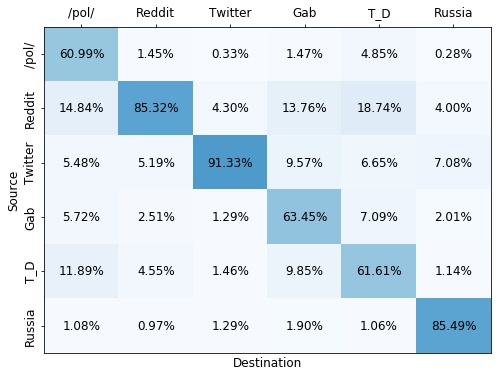

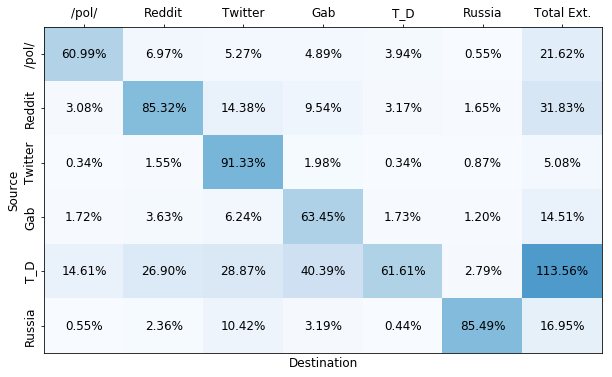

In [24]:
hawkes_russians = load_hawkes_output('./data/hawkes_output_russians/')
# overall influence for both URLs shared by Russian trolls
processes_names_russians = ['4chan', 'redd', 'twit', 'gab', 'td', 'russ']
pretty_processes_names_russians = ['/pol/', 'Reddit', 'Twitter', 'Gab', 'T_D', 'Russia']
influence_heatmap_single(hawkes_russians, processes_names_russians, pretty_processes_names_russians,
                         './figures/hawkes_influence_russians.pdf')
normalized_influence_single(hawkes_russians, processes_names_russians, pretty_processes_names_russians,
                           './figures/hawkes_norm_influence_russians.pdf')

## Figures 14  (b) and 15 (b). Influence Estimation for URLs shared by Iranian trolls


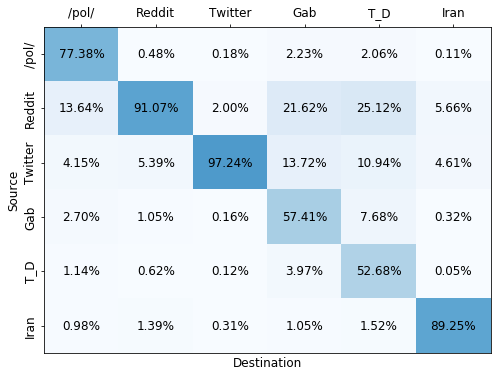

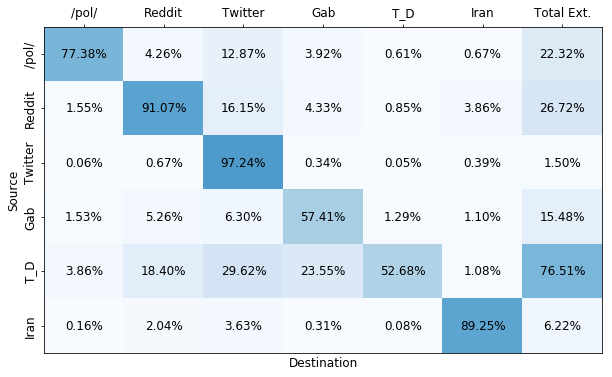

In [25]:
hawkes_iranians = load_hawkes_output('./data/hawkes_output_iranians/')
# overall influence for both URLs shared by Russian trolls
processes_names_iranians = ['4chan', 'redd', 'twit', 'gab', 'td', 'iran']
pretty_processes_names_iranians = ['/pol/', 'Reddit', 'Twitter', 'Gab', 'T_D', 'Iran']
influence_heatmap_single(hawkes_iranians, processes_names_iranians, pretty_processes_names_iranians,
                         './figures/hawkes_influence_russians.pdf')
normalized_influence_single(hawkes_iranians, processes_names_iranians, pretty_processes_names_iranians,
                           './figures/hawkes_norm_influence_russians.pdf')

## Figures 14  (c) and 15 (c). Influence Estimation for URLs shared by both Russian and Iranian trolls

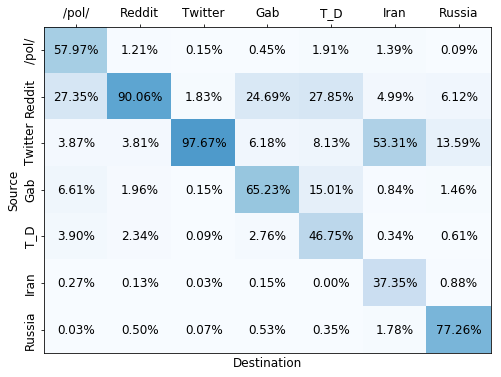

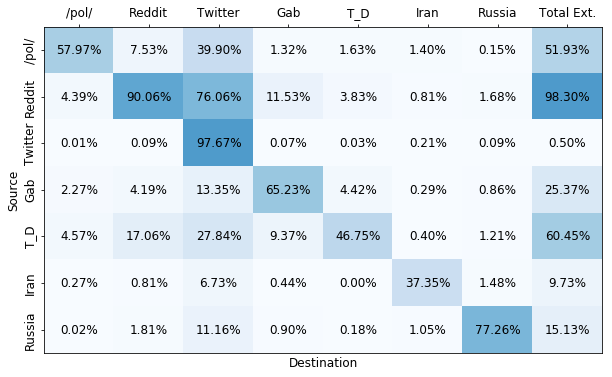

In [26]:
hawkes_both = load_hawkes_output('./data/hawkes_output_both/')
# overall influence for both URLs shared by Russian and Iranian trolls
processes_names_both = ['4chan', 'redd', 'twit', 'gab', 'td', 'iran', 'russ']
pretty_processes_names_both = ['/pol/', 'Reddit', 'Twitter', 'Gab', 'T_D', 'Iran', 'Russia']
influence_heatmap_single(hawkes_both, processes_names_both, pretty_processes_names_both,
                         './figures/hawkes_influence_both.pdf')
normalized_influence_single(hawkes_both, processes_names_both, pretty_processes_names_both,
                           './figures/hawkes_norm_influence_both.pdf')

# Table 7 (Table 8 in arxiv version, Statistics of Hawkes Processes Events)

In [27]:
def generate_events_table(list_dfs, names_dataframes):
    all_results = []
    for i in range(len(list_dfs)):
        df = list_dfs[i]
        df = df.dropna()
        res = {}
        for k in processes_names_both:
            try:
                key =  'n_' + k
                s = sum(df[key].tolist())
            except:
                s = 0
            res[k] = s
        all_results.append(pd.DataFrame.from_dict({names_dataframes[i]:res}, orient='index'))
    return pd.concat(all_results, axis=0)

def find_total_number_urls(list_dfs):
    all_results = []
    for i in range(len(list_dfs)):
        df = list_dfs[i]
        df = df.dropna()
        all_results.append(len(df['url'].tolist()))
    return all_results

# create dict with mapping for column names
mapping_column_names = {}
for i in range(len(processes_names_both)):
    mapping_column_names[processes_names_both[i]] = pretty_processes_names_both[i]

table_7 = generate_events_table([hawkes_russians, hawkes_iranians, hawkes_both], ['Russians', 'Iranians', 'Both'])
table_7 = table_7.rename(columns=mapping_column_names)
# now we need to add the total number of events 
table_7['Total Events'] = table_7.sum(axis=1)
# and the total_number of URLs
table_7['URLs'] = find_total_number_urls([hawkes_russians, hawkes_iranians, hawkes_both])

table_7

,/pol/,Reddit,Twitter,Gab,T_D,Iran,Russia,Total Events,URLs
Russians,76155,366319,1225550,254016,61968,0,151222,2135230,48497
Iranians,3274,28812,232898,5763,971,19629,0,291347,4692
Both,331,2060,85467,962,283,334,565,90002,153
